# Temporal Shift Detection in ICU Patient Data


In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from pathlib import Path

sns.set(style="whitegrid")
%matplotlib inline


# Load Patient Data with Timestamps




In [25]:
# load patient data with hospital/unit info
patient_path = Path("eicu-collaborative-research-database-2.0/patient.csv.gz") 
df_pat = pd.read_csv(patient_path, compression="gzip")

# relevant columns
df_pat = df_pat[['patientunitstayid', 'hospitalid', 'unittype']]

#check info
df_pat.info()
df_pat.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200859 entries, 0 to 200858
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   patientunitstayid  200859 non-null  int64 
 1   hospitalid         200859 non-null  int64 
 2   unittype           200859 non-null  object
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


,patientunitstayid,hospitalid,unittype
0,141168,59,Med-Surg ICU
1,141178,60,Med-Surg ICU
2,141179,60,Med-Surg ICU
3,141194,73,CTICU
4,141196,67,Med-Surg ICU


In [26]:

diag_path = Path("eicu-collaborative-research-database-2.0/diagnosis.csv.gz") 
df_diag = pd.read_csv(diag_path, compression="gzip")

#check info
df_diag.info()
df_diag.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2710672 entries, 0 to 2710671
Data columns (total 7 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   diagnosisid          int64 
 1   patientunitstayid    int64 
 2   activeupondischarge  bool  
 3   diagnosisoffset      int64 
 4   diagnosisstring      object
 5   icd9code             object
 6   diagnosispriority    object
dtypes: bool(1), int64(3), object(3)
memory usage: 126.7+ MB


,diagnosisid,patientunitstayid,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority
0,4222318,141168,False,72,cardiovascular|chest pain / ASHD|coronary arte...,"414.00, I25.10",Other
1,3370568,141168,True,118,cardiovascular|ventricular disorders|cardiomyo...,NaN,Other
2,4160941,141168,False,72,pulmonary|disorders of the airways|COPD,"491.20, J44.9",Other
3,4103261,141168,True,118,pulmonary|disorders of the airways|COPD,"491.20, J44.9",Other
4,3545241,141168,True,118,cardiovascular|ventricular disorders|congestiv...,"428.0, I50.9",Other


In [27]:
# Use patientunitstayid as a proxy for time
df_pat = df_pat.dropna(subset=["patientunitstayid"])
df_pat["pseudo_time"] = pd.qcut(df_pat["patientunitstayid"], q=2, labels=["early", "late"])

#merging 
df = df_diag.merge(df_pat[["patientunitstayid", "pseudo_time"]], on="patientunitstayid", how="left")
df = df.dropna(subset=["pseudo_time", "diagnosispriority"])

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2710672 entries, 0 to 2710671
Data columns (total 8 columns):
 #   Column               Dtype   
---  ------               -----   
 0   diagnosisid          int64   
 1   patientunitstayid    int64   
 2   activeupondischarge  bool    
 3   diagnosisoffset      int64   
 4   diagnosisstring      object  
 5   icd9code             object  
 6   diagnosispriority    object  
 7   pseudo_time          category
dtypes: bool(1), category(1), int64(3), object(3)
memory usage: 129.3+ MB


,diagnosisid,patientunitstayid,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority,pseudo_time
0,4222318,141168,False,72,cardiovascular|chest pain / ASHD|coronary arte...,"414.00, I25.10",Other,early
1,3370568,141168,True,118,cardiovascular|ventricular disorders|cardiomyo...,NaN,Other,early
2,4160941,141168,False,72,pulmonary|disorders of the airways|COPD,"491.20, J44.9",Other,early
3,4103261,141168,True,118,pulmonary|disorders of the airways|COPD,"491.20, J44.9",Other,early
4,3545241,141168,True,118,cardiovascular|ventricular disorders|congestiv...,"428.0, I50.9",Other,early


# Define Temporal Cohorts




In [28]:
# Encode diagnosispriority to numeric
df["diagnosispriority_encoded"] = pd.factorize(df["diagnosispriority"])[0]
feature = "diagnosispriority_encoded"

# Visualize Feature Distribution Over Time



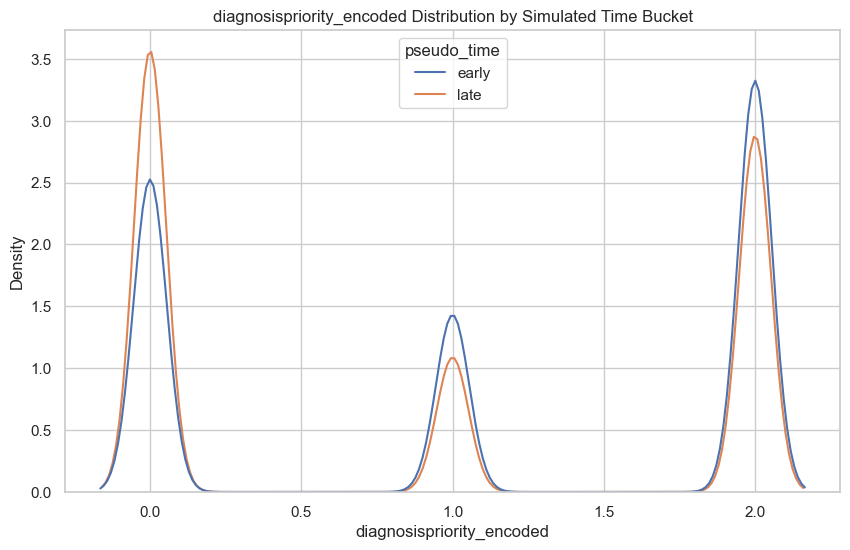

In [29]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x=feature, hue="pseudo_time", common_norm=False)
plt.title(f"{feature} Distribution by Simulated Time Bucket")
plt.xlabel(feature)
plt.ylabel("Density")
plt.show()

# Statistical Test for Temporal Drift



In [30]:
group1 = df[df["pseudo_time"] == "early"][feature].dropna()
group2 = df[df["pseudo_time"] == "late"][feature].dropna()

stat, p = ks_2samp(group1, group2)
print(f"KS Statistic = {stat:.4f}")
print(f"P-value = {p:.4f}")


KS Statistic = 0.1266
P-value = 0.0000


# Save Temporal Cohort Splits



In [31]:
early_df = df[df["pseudo_time"] == "early"]
late_df = df[df["pseudo_time"] == "late"]

Path("cohorts").mkdir(exist_ok=True)
early_df.to_csv("cohorts/train_temporal.csv", index=False)
late_df.to_csv("cohorts/test_temporal.csv", index=False)


In [32]:
#making sample size 
# full cohort output from notebook 
df_train = pd.read_csv("cohorts/train_temporal.csv")
df_test = pd.read_csv("cohorts/test_temporal.csv")

# Random sample of 500 rows (for demo/testing)
sample_df_train = df_train.sample(n=500, random_state=42)
sample_df_test = df_test.sample(n=500, random_state=42)

# Save this
sample_df_train.to_csv("cohorts/train_temporal_sample.csv", index=False)
sample_df_test.to_csv("cohorts/test_temporal_sample.csv", index=False)


# Summary

This notebook successfully:
- Identified a temporal feature (`hospitaladmitoffset`)
- Defined early vs. late admission cohorts
- Quantified distribution shift in clinical features
- Saved shifted datasets for modeling

These steps support later experiments in:
- Evaluating baseline model robustness over time
- Testing In-Context Learning (ICL) strategies for temporal generalization
